In [9]:
!pip install aipilot --upgrade -q 
!pip install -r requirements.txt -q

## Imports

In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
import os                  
from PIL import Image
import pandas as pd 

import tensorflow as tf
import keras 
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Activation, Dropout, BatchNormalization  
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model

from inference import Inference
from aipilot.tf.cv import DataPrep , GradCam
from aipilot.tf import Devices, callbacks, Evaluator
import cv2

In [2]:
devices = Devices()

In [3]:
devices.gpu_device

[INFO] Tensorflow is built with cuda support ✅
[INFO] [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[INFO] {'device_name': 'NVIDIA GeForce RTX 3050 Ti Laptop GPU', 'compute_capability': (8, 6)}


## Project Directories

In [4]:
BASE_DIR = os.path.relpath(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, "dataset") 

ARTIFACTS_DIR = os.path.join(BASE_DIR, 'artifacts')
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

CKPT_DIR = os.path.join(ARTIFACTS_DIR, "ckpt")
os.makedirs(CKPT_DIR, exist_ok=True)

MODELS_DIR = os.path.join(ARTIFACTS_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

LOGS_DIR = os.path.join(BASE_DIR, "logs")
os.makedirs(LOGS_DIR, exist_ok=True)

CKPT_FILE_NAME = os.path.join(CKPT_DIR, ".mdl_wts.hdf5")
MODEL_NAME = os.path.join(MODELS_DIR, "model.h5")

## Data Preprocessing

In [5]:
def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

def apply_white_balance(DATA_DIR):
    classes =os.listdir(DATA_DIR)
    for cls in classes:
        all_images = os.listdir(os.path.join(DATA_DIR, cls))
        for img in all_images:
            img = os.path.join(DATA_DIR, cls, img)
            if img.endswith(('.jpg','.png', '.jpeg', '.JPG', '.PNG', '.JPEG')):
                # load the image, swap color channels, and resize it to be a fixed
                # 224x224 pixels while ignoring aspect ratio
                image = cv2.imread(img)
                # performing white balance
                imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
                gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
                rgb_img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
                image = cv2.resize(rgb_img, (224, 224))
                print(img)
                cv2.imwrite(img, image)

In [6]:
#apply_white_balance(DATA_DIR)

In [7]:
data_ops = DataPrep(DATA_DIR)

In [8]:
custom_data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=15,
            horizontal_flip=True,
            rescale=1./255,
            validation_split= 0.2)
train_generator, valid_generator = data_ops.data_generators( val_split=0.2, batch_size=16,
                                                            data_augmentation= True,
                                                            augmentation_strategy= custom_data_augmentation)
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

Found 1368 images belonging to 3 classes.
Found 340 images belonging to 3 classes.


In [9]:
type(valid_generator)

keras.preprocessing.image.DirectoryIterator

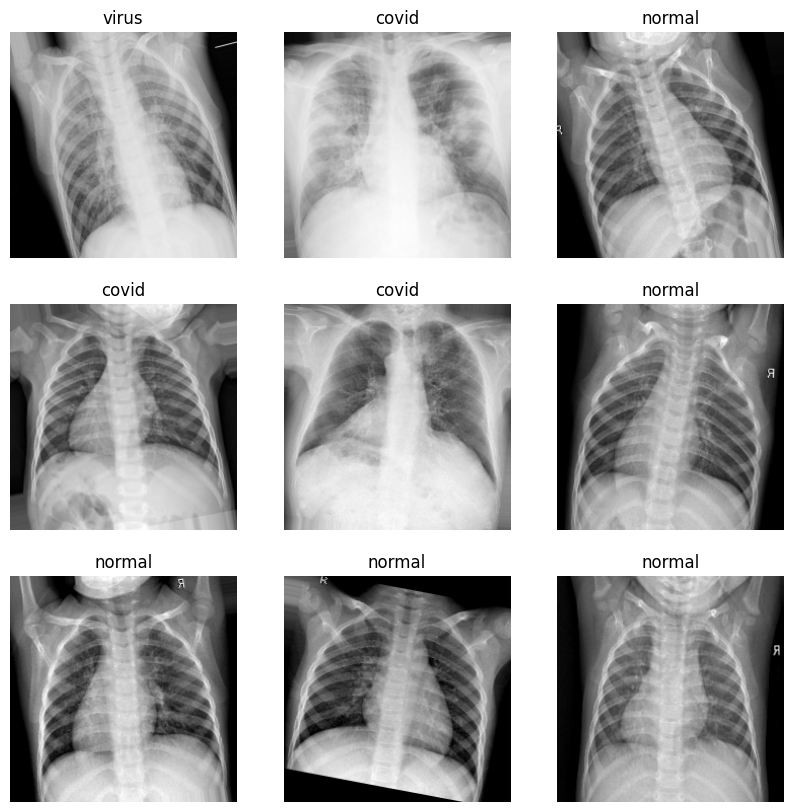

In [12]:
img = data_ops.sample_images(train_generator)

## Model Training

In [14]:
(early_stopping_cb, checkpointing_cb,
 tensorboard_cb, reduce_on_plateau_cb) = callbacks(
                                                   CKPT_FILE_NAME,LOGS_DIR, es_patience=10, lr_patience=4
                                                    )

In [15]:
## DenseNet201
conv_base = DenseNet201(
        include_top=False,
        weights='imagenet'
)
for layer in conv_base.layers[:-5]:
    layer.trainable = False

In [16]:
x = conv_base.output    
x = GlobalAveragePooling2D()(x)
x = Dense(units=512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(units=64)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(units=32, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, outputs = predictions)

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [18]:
history = []

In [ ]:
h = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=100,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks = [tensorboard_cb , early_stopping_cb, checkpointing_cb, reduce_on_plateau_cb]
    )
history.append(h)

In [ ]:
saved_ckpt = os.path.join( CKPT_DIR, CKPT_FILE_NAME)
loaded_ckpt = keras.models.load_model(saved_ckpt)

In [22]:
#starting the training again from the last checkpoint
h = loaded_ckpt.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=1,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks = [tensorboard_cb , early_stopping_cb, checkpointing_cb, reduce_on_plateau_cb]
    )
history.append(h)

85/85 [==============================] - 41s 478ms/step - loss: 0.0471 - accuracy: 0.9867 - val_loss: 0.1997 - val_accuracy: 0.9375 - lr: 2.0000e-04


In [23]:
history_df = pd.DataFrame()
for h in history:
    history_df = pd.concat([history_df, pd.DataFrame.from_records(h.history)])

In [ ]:
history_df.reset_index(drop=True).plot(figsize= (8,5));

## Saving and Loading Model

In [71]:
model = load_model(os.path.join(CKPT_DIR, CKPT_FILE_NAME))
model.save(MODEL_NAME)

In [20]:
model = load_model(MODEL_NAME)

## Model Evaluation

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs 

In [73]:
#Get the last conv layer name
for layer in model.layers[-20:]:
    print(layer.name)

conv5_block32_1_bn
conv5_block32_1_relu
conv5_block32_2_conv
conv5_block32_concat
bn
relu
global_average_pooling2d
dense
batch_normalization
activation
dropout
dense_1
batch_normalization_1
activation_1
dropout_1
dense_2
batch_normalization_2
activation_2
dense_3
dense_4


In [115]:
inference = Inference()
inference.apply_white_balance(input_img_path = "./test_data/covid.jpg", output_img_path = "./test_data/covid_wb.jpg")

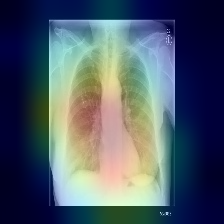

In [116]:
gradcam = GradCam(model, "conv5_block32_concat", "./test_data/covid_wb.jpg",  normalize_img=True)
gradcam.get_gradcam()

In [117]:
# Prediction through GradCam
gradcam.preds.numpy()

array([[9.9999845e-01, 2.8570213e-07, 1.2785758e-06]], dtype=float32)

In [21]:
# checking the accuracy 
result = model.evaluate(valid_generator)
print('\n', 'Validation Loss:', round(result[0], 3))
print('\n', 'Validation Accuracy:', round(result[1], 3))

22/22 [==============================] - 9s 261ms/step - loss: 0.1845 - accuracy: 0.9500

 Validation Loss: 0.185

 Validation Accuracy: 0.95


In [26]:
type(result[0])

float

In [82]:
eval= Evaluator(model, train_generator, valid_generator)

22/22 [==============================] - 2s 103ms/step


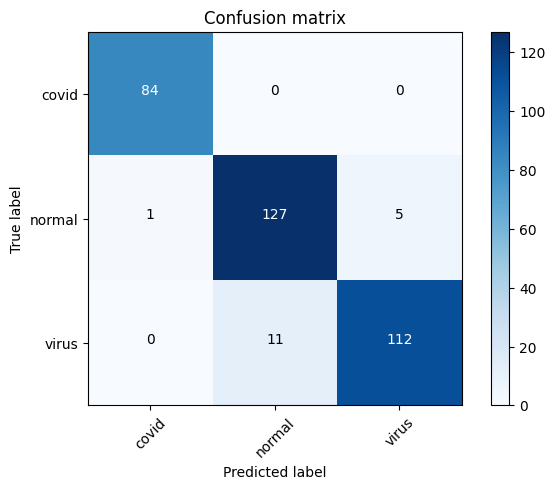

In [83]:
eval.confusion_matrix()

In [84]:
eval.classification_report()

              precision    recall  f1-score   support

       covid       1.00      0.99      0.99        85
      normal       0.95      0.92      0.94       138
       virus       0.91      0.96      0.93       117

    accuracy                           0.95       340
   macro avg       0.96      0.96      0.95       340
weighted avg       0.95      0.95      0.95       340



In [85]:
print(train_generator.class_indices)
images, labels = valid_generator.next()
predictions = model.predict(np.expand_dims(images[0], axis=0))
np.argmax(predictions[0])

{'covid': 0, 'normal': 1, 'virus': 2}
1/1 [==============================] - 2s 2s/step


0

Found 1368 images belonging to 3 classes.
Found 340 images belonging to 3 classes.
1/1 [==============================] - 0s 33ms/step


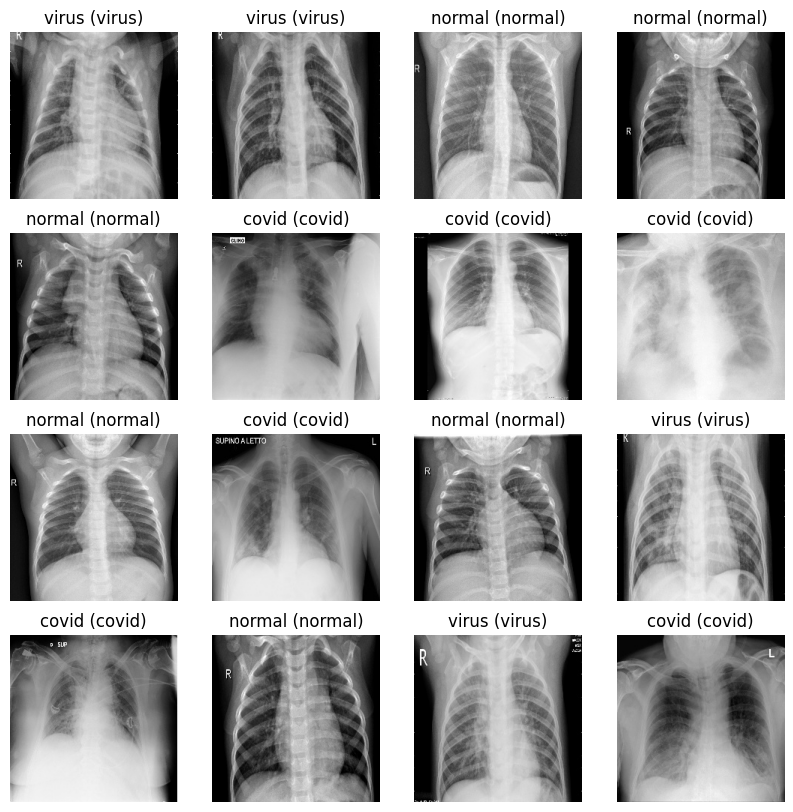

In [86]:
_, valid_generator_with_shuffle  = data_ops.data_generators( val_split=0.2,val_shuffle=True, batch_size=16, data_augmentation= False)
#_, valid_generator_with_shuffle = data_ops.data_generators(train_dir=DATA_DIR, val_shuffle=True, val_dir=TEST_DIR, batch_size=16)
#plot a random sample of test images, their predicted labels, and ground truth
classes = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
images, labels = valid_generator_with_shuffle.next()
labels = np.argmax(labels, axis=1)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    prediction = classes[np.argmax(model.predict(np.expand_dims(images[i], axis=0))[0], axis=0)]
    plt.imshow(images[i])
    plt.title(f"{classes[labels[i]]} ({prediction})")
    plt.axis("off")

In [124]:
## Making prediction
img_arr = np.asarray(Image.open("./dataset/normal/NORMAL2-IM-0489-0001.jpeg"))
img_arr =  np.expand_dims(img_arr, axis=0)/255.0
prediction = np.round(model.predict(img_arr), decimals = 6)
prediction

1/1 [==============================] - 0s 33ms/step


array([[6.00000e-06, 9.99989e-01, 5.00000e-06]], dtype=float32)

In [125]:
prediction = model.predict(img_arr)
pred_cls_label = np.argmax(prediction, axis=1)[0]
pred_cls_label

1/1 [==============================] - 0s 32ms/step


1

In [126]:
train_generator.class_indices

{'covid': 0, 'normal': 1, 'virus': 2}

In [127]:
np.set_printoptions(suppress=True)
print(f"Probability of being Covid-19 is {round(prediction[0][0]*100, 5)} %")
print(f"Probability of being Virus is {round(prediction[0][2]*100, 5)} %")
print(f"Probability of being Normal is {round(prediction[0][1]*100, 5)} %")

Probability of being Covid-19 is 0.00062 %
Probability of being Virus is 0.00046 %
Probability of being Normal is 99.99893 %


In [128]:
pred_cls = eval.class_names[pred_cls_label]
pred_cls

'normal'